In [ ]:
#Run cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import sys
import h5py

#append repo folder to search path
sys.path.append('/content/drive/MyDrive/limb-position-EMG-Repo/')
from utils import *


In [ ]:
#define where the data files are located
data_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/'

nsubjects = 36


# User-defined parameters
lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

#excluded labels
exclude = [0]

#for subject_id in range(nsubjects,nsubjects+1):
subject_id = 1
subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
print('=======================')
print(subject_folder)

# Process data and get features 
#get features across segments and corresponding info
feature_matrix_sub, target_labels_sub, window_tstamps_sub, \
block_labels_sub, series_labels_sub = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                win_size, step)

/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/01


In [ ]:
train_idxs = np.where(series_labels_sub==0)[0]
test_idxs = np.where(series_labels_sub==1)[0]

X = feature_matrix_sub.copy()
Y = target_labels_sub.copy()
block_labels = block_labels_sub.copy()
tstamps = window_tstamps_sub.copy()

exclude =[0,7]
magic_value = -100


In [ ]:
verbose = 0
epochs = 40
batch_size = 2

In [ ]:
X_train =  X[train_idxs,:]
Y_train = Y[train_idxs]
block_labels_train = block_labels[train_idxs]

scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)



In [ ]:
#simple training cube


# #replace excluded values with magic value
# exclude_idxs = np.where(np.isin(Y_train,exclude))[0]
# include_idxs = np.where(np.isin(Y_train,exclude, invert = True))[0]
# #one-hot encoding of class labels
# Y_train = to_categorical(Y_train-np.min(Y_train[include_idxs]))
# X_train[exclude_idxs,:] = magic_value
# Y_train[exclude_idxs,:] = magic_value
# X_train = np.expand_dims(X_train,0)
# Y_train = np.expand_dims(Y_train,0)

# X_train_cube = X_train.copy()
# Y_train_cube = Y_train.copy()


In [ ]:
nsets = 10
X_train_cube = np.empty((0,0,0))
Y_train_cube = np.empty((0,0,0))
for s in range(nsets):

    blocks = np.array([k for k,g in groupby(block_labels_train)])
    classes = np.array([k for k,g in groupby(Y_train)])

    #shuffle blocks, keeping preceding blank block for each 
    # shuffled_blocks = []
    # for x in np.random.permutation(np.arange(blocks.size//2)):
    #     start_idx = 2*x
    #     shuffled_blocks.extend(blocks[start_idx:start_idx+2].astype('int'))
    # if (blocks.size%2)==1:
    #     shuffled_blocks.extend(np.array([blocks[-1]]).astype('int'))
    shuffled_blocks = blocks

    Y_blocks_shuffled = np.empty((0,))
    X_blocks_shuffled = np.empty((0,0))
    for b in shuffled_blocks:
        block_idxs = np.where(block_labels_train==b)[0]
        Y_blocks_shuffled = np.hstack((Y_blocks_shuffled,Y_train[block_idxs]))
        X_blocks_shuffled = np.vstack((X_blocks_shuffled,X_train[block_idxs,:])) if X_blocks_shuffled.size else X_train[block_idxs,:]

    #replace excluded values with magic value
    exclude_idxs = np.where(np.isin(Y_blocks_shuffled,exclude))[0]
    include_idxs = np.where(np.isin(Y_blocks_shuffled,exclude, invert = True))[0]
#     #one-hot encoding of class labels
    Y_blocks_shuffled = to_categorical(Y_blocks_shuffled)[:,1:]
    X_blocks_shuffled[exclude_idxs,:] = magic_value
    Y_blocks_shuffled[exclude_idxs,:] = magic_value


    # stack batched
    X_train_cube = np.dstack((X_train_cube, X_blocks_shuffled.T)) if X_train_cube.size else X_blocks_shuffled.T
    Y_train_cube = np.dstack((Y_train_cube, Y_blocks_shuffled.T)) if Y_train_cube.size else Y_blocks_shuffled.T
#swap for batch-major axes arrangement
X_train_cube = np.swapaxes(X_train_cube,0,2)
Y_train_cube = np.swapaxes(Y_train_cube,0,2)

In [ ]:

n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_train_cube.shape[2]

#setting timestep dimension to None 
model = many_to_many_model((None,n_features),n_outputs,mask_value = -100)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary

print('Training Model')
# fit network
history = model.fit(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=verbose)

print('Evaluating Model')


Training Model
Evaluating Model


In [ ]:
get_RNN_f1(X_train_cube, Y_train_cube, model)

0.9954537583628493

In [ ]:
X_test =  X[test_idxs,:]
Y_test = Y[test_idxs]
tstamps_test = tstamps[test_idxs]

# X_test =  X[train_idxs,:]
# Y_test = Y[train_idxs]
# tstamps_test = tstamps[train_idxs]
#if test_idxs.size:

X_test = scaler.transform(X_test)
#replace excluded values with magic value
exclude_idxs = np.where(np.isin(Y_test,exclude))[0]
include_idxs = np.where(np.isin(Y_test,exclude, invert = True))[0]
#one-hot encoding of class labels
Y_test = to_categorical(Y_test)[:,1:]
X_test[exclude_idxs,:] = magic_value
Y_test[exclude_idxs,:] = magic_value
X_test = np.expand_dims(X_test,0)
Y_test = np.expand_dims(Y_test,0)

X_test_cube = X_test.copy()
Y_test_cube = Y_test.copy()

array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
get_RNN_f1(X_test_cube, Y_test_cube, model)


0.8372743637156842

In [ ]:
X_fn = X_test_cube.copy()
Y_fn = Y_test_cube.copy()
mask_value = -100
nonmasked_idxs = np.where(Y_fn[:,:,0].flatten()!=mask_value)[0]
masked_idxs = np.where(Y_fn[:,:,0].flatten()==mask_value)[0]
# Get target labels for non-masked timepoints
y_true = np.argmax(Y_fn,2).flatten()[nonmasked_idxs]
# Get model predictions for non-masked timepoints
preds = model.predict(X_fn)
y_pred = np.argmax(preds,2).flatten()[nonmasked_idxs]

In [ ]:
np.sum(y_true==y_pred)/y_pred.size

0.759090909090909

In [ ]:
f1_score(y_true,y_pred,average = 'weighted')

0.6976124398532708

In [ ]:
#X_test =  X[test_idxs,:]

X_test =  X[train_idxs,:]
X_test = scaler.transform(X_test)
X_test = np.expand_dims(X_test,0)
X_test_cube = X_test.copy()

In [ ]:
X_test_cube.shape

(1, 641, 16)

In [ ]:
y_prob = np.squeeze(model.predict(X_test_cube))

y_pred = np.argmax(y_prob,1)+1

In [ ]:
class_labels = np.squeeze(np.argmax(Y_test_cube,2))+1
masked_idxs = np.where(Y_test_cube[:,:,0].flatten()==mask_value)[0]
class_labels[masked_idxs] = 0

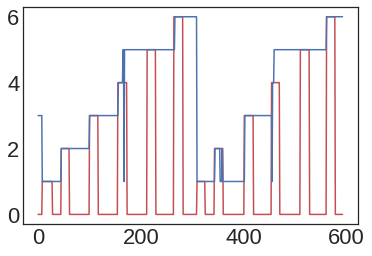

In [ ]:
plt.plot(class_labels,'r')
plt.plot(y_pred,'b')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [ ]:
#start_times, end_times,event_labels


#taking advantage that every gesture is preceded by a period with 'undefined' class label (value 0)
start_idxs = np.hstack([0,np.where(np.abs(np.diff(class_labels))>0)[0]+1])

#end indices correspond to just before the start of the next condition
end_idxs = np.hstack((start_idxs[1:]-1,class_labels.size-1))


#create arrays with start times and class labels for each hand gesture
start_times = tstamps_test[start_idxs]
end_times = tstamps_test[end_idxs]
event_labels = class_labels[start_idxs]

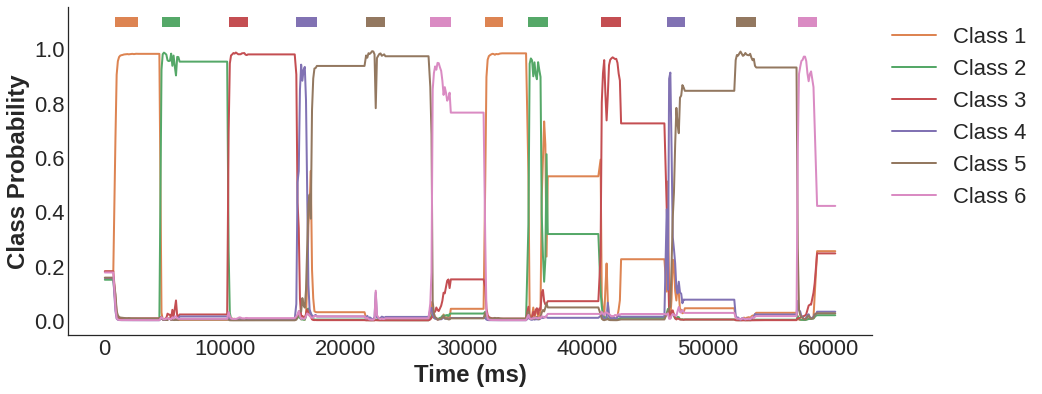

In [ ]:

classes = np.unique(event_labels)[1:]#exclude 'unmarked' label
labels = []
for c in classes.astype('int'):
    labels.append('Class %i'%(c))

# define color palette
palette = sns.color_palette('deep',8)[1:]

plt.figure(figsize=(15,6))
plt.gca().set_prop_cycle(plt.cycler('color',palette))
plt.plot(tstamps_test,y_prob, linewidth = 2);

#mark events
for idx,c in enumerate(event_labels):
    if c>0:
        plt.hlines(y = 1.1, xmin = start_times[idx], xmax = end_times[idx], color = palette[c-1],linewidth = 10)

#label axes
plt.ylabel('Class Probability')
plt.xlabel('Time (ms)')

plt.legend(labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = False)

plt.gcf().tight_layout() 

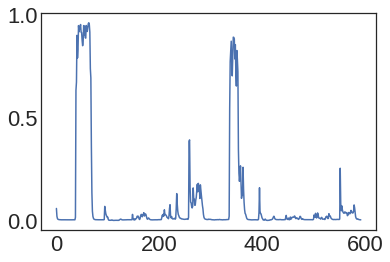

In [ ]:
plt.plot(y_prob[:,1])

In [ ]:
X_blocks_shuffled.shape

(641, 16)

In [ ]:
ef RNN_on_labeled_data(feature_matrix, target_labels, window_tstamps, block_labels, n_splits = 4,\
                       verbose = 0, epochs = 40, batch_size = 2, permute = False):
    """
    Train and evaluate RNN model on labeled data
    
    Args:
        feature_matrix: 2D nuumpy array with data, dimensions [features, samples]
        window_blocks: 1D numpy array indicating block of provenance for input segment values
        train: Boolean indicating whether the input data is training data
        scaler: StandardScaler to transform data
        magic_value: integer indicating value with which to pad samples
            
    Returns:
        train_f1_scores: training scores for each split
        test_f1_scores: test scores for each split


    """
    
    # transpose data
    #feature_matrix = feature_matrix.T
    
    #initialize empty array
    train_f1_scores = np.empty((n_splits,))
    test_f1_scores = np.empty((n_splits,))


    #get block_ids and corresponding classes in block. there are the units over which we will do train/test split
    blocks = np.array([k for k,g in groupby(block_labels)])
    classes = np.array([k for k,g in groupby(target_labels) if k!=0])
    
    #permute class labels, if indicated
    if permute:
        #using indexing tricks to have this work out
        classes_perm = np.random.permutation(classes)
        target_labels_shuffled = np.empty((0,))
        for i,b in enumerate(blocks):
            idxs = np.where(block_labels==b)[0]
            target_labels_shuffled = np.hstack((target_labels_shuffled,classes_perm[i]*np.ones((idxs.size,))))
        target_labels = target_labels_shuffled
        classes = classes_perm
     
    
    #stratify split to retain ratio of class labels
    skf = StratifiedKFold(n_splits=n_splits,shuffle = True)
    print(block_labels.shape)
    print(target_labels.shape)
    print(blocks.shape,classes.shape)

    #systematically use one fold of the data as a held-out test set
    for split_count, (blocks_train_idxs, blocks_test_idxs) in enumerate(skf.split(blocks, classes)):
        print('Split Count: %i'% (split_count+1))

        #get train and test indices
        blocks_train = blocks[blocks_train_idxs]
        blocks_test = blocks[blocks_test_idxs]
        train_idxs =np.where(np.isin(block_labels,blocks_train))[0]
        test_idxs =np.where(np.isin(block_labels,blocks_test))[0]

        # select training data and pad to get an array where each sample has same number of timesteps
        X_train = feature_matrix[:,train_idxs]
        y_train = target_labels[train_idxs]
        #one-hot encoding of class labels
        y_train = to_categorical(y_train-np.min(y_train))
        #get block labels of given samples
        win_blocks_train = block_labels[train_idxs]

        #get cube
        X_train_cube, Y_train_cube, scaler = get_data_cube(X_train, y_train,win_blocks_train, train = True, magic_value = -100)
        print(X_train_cube.shape, Y_train_cube.shape)

        # select test data and pad to get an array where each sample has same number of timesteps
        X_test = feature_matrix[:,test_idxs]
        y_test = target_labels[test_idxs]
        #one-hot encoding of class labels
        y_test = to_categorical(y_test-np.min(y_test))
        #get block labels of given samples
        win_blocks_test = block_labels[test_idxs]
        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)
        print(X_test_cube.shape, Y_test_cube.shape)

        n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_test_cube.shape[2]

        #setting timestep dimension to None 
        model = many_to_many_model((None,n_features),n_outputs,mask_value = -100)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #model.summary

        print('Training Model')
        # fit network
        model.fit(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print('Evaluating Model')
        #evaluate model on train and test data
        train_f1_scores[split_count] = get_RNN_f1(X_train_cube, Y_train_cube, model)
        test_f1_scores[split_count] = get_RNN_f1(X_test_cube, Y_test_cube, model)